In [343]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import requests as req
import emcee
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy.optimize import minimize
%matplotlib inline

In [344]:
print(np.__version__)
print(pd.__version__)
print(req.__version__)
print(emcee.__version__)
print(matplotlib.__version__)
print(scipy.__version__)

1.16.0
0.24.1
2.21.0
2.2.1
3.0.3
1.2.0


# Introduction

The stated purpose of this notebook is to explore some cryptocurrency data. Yahoo! doesn't seem to allow programmatic access to its financial data, including crypto data. I felt that scraping data is outside of the scope of this project and so I opted to use a [different API](https://cryptocompare.com) which provides similar data, instead.

We begin by exploring the API a little bit. We then request extensive historical price data on several cryptocurrencies. After briefly analyzing some of the summary statistics of the data, we begin to work on a predictive model of asset returns, concluding with an application to portfolio selection. Finally, we analyze some of the flaws in the model and possible revisions.

# Exploration

In [3]:
endpoint = "https://min-api.cryptocompare.com/data/"
api_key = "f42555b48bbf03e7f64fdbfde60ebe62905fd2103ec9beada0969c3d81c749a8"

In [4]:
def req_url(meth, params):
    params["api_key"] = api_key
    
    return endpoint + meth + "?" + "&".join(["{}={}".format(k, v) for k, v in params.items()])

First, we'll request the top 100 crypto symbols by volume, so that we can request the prices of them:

In [5]:
meth = "top/totalvolfull"
params = {}
params["limit"] = 100
params["tsym"] = "USD"

ru = req_url(meth, params)
data = req.get(ru).json()['Data']
top = list(map(lambda c: c['CoinInfo']['Name'], data))
n_top = len(top)

We can only request 1 crypto symbol at a time. We'll request 3 years of data:

In [6]:
meth = "histoday"

n_top = 10
raw_data = {}
for i in range(n_top):
    params = {}
    params["fsym"] = top[i]
    params["tsym"] = "USD"
    params["limit"] = 2 * 365 + 30
    ru = req_url(meth, params)
    raw_data[top[i]] = req.get(ru).json()['Data']

In [7]:
raw_data.keys()

dict_keys(['BTC', 'ETH', 'EOS', 'LTC', 'XRP', 'ZEC', 'BCH', 'ENJ', 'XLM', 'QTUM'])

We'll extract the daily lows and highs, and the closing prices, for each currency, and store them in separate data frames:

In [8]:
lows = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["low"], raw_data[ticker])), raw_data.keys()))).T
highs = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["high"], raw_data[ticker])), raw_data.keys()))).T
closes = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["close"], raw_data[ticker])), raw_data.keys()))).T

In [9]:
df_lows = pd.DataFrame(lows)
df_highs = pd.DataFrame(highs)
df_closes = pd.DataFrame(closes)

In [10]:
df_lows.columns = top[:n_top]
df_highs.columns = top[:n_top]
df_closes.columns = top[:n_top]

In [11]:
df_closes.head()

,BTC,ETH,EOS,LTC,XRP,ZEC,BCH,ENJ,XLM,QTUM
0,978.96,10.94,0.0,3.67,0.00628,32.57,0.0,0.0,0.002056,0.0
1,997.61,11.34,0.0,3.76,0.00631,32.51,0.0,0.0,0.002181,0.0
2,1008.32,11.43,0.0,3.81,0.00638,32.58,0.0,0.0,0.002319,0.0
3,996.52,11.42,0.0,3.73,0.00627,31.04,0.0,0.0,0.002168,0.0
4,995.36,11.39,0.0,3.74,0.00624,30.71,0.0,0.0,0.002168,0.0


We'll remove currencies that haven't been actively traded for at least the time we're interested in:

In [35]:
df_closes = df_closes.replace(0.0, np.nan).dropna(axis=1)
df_closes.head()

,BTC,ETH,LTC,XRP,ZEC,XLM
0,978.96,10.94,3.67,0.00628,32.57,0.002056
1,997.61,11.34,3.76,0.00631,32.51,0.002181
2,1008.32,11.43,3.81,0.00638,32.58,0.002319
3,996.52,11.42,3.73,0.00627,31.04,0.002168
4,995.36,11.39,3.74,0.00624,30.71,0.002168


Generally, the return on an asset is defined as $x(t + 1)/x(t)$, where $x(t)$ is the asset price at time $t$:

In [12]:
def returns(x):
    T = len(x)
    r = np.zeros(T - 1)
    for t in range(T - 1):
        r[t] = x[t+1]/x[t]
    
    return r

In [36]:
df_returns = df_closes.apply(lambda x: pd.Series(returns(x)), axis=0)

In [37]:
df_returns.head()

,BTC,ETH,LTC,XRP,ZEC,XLM
0,1.019051,1.036563,1.024523,1.004777,0.998158,1.060798
1,1.010736,1.007937,1.013298,1.011094,1.002153,1.063274
2,0.988297,0.999125,0.979003,0.982759,0.952732,0.934886
3,0.998836,0.997373,1.002681,0.995215,0.989369,1.000000
4,1.013041,1.141352,1.016043,0.996795,1.079453,0.872694


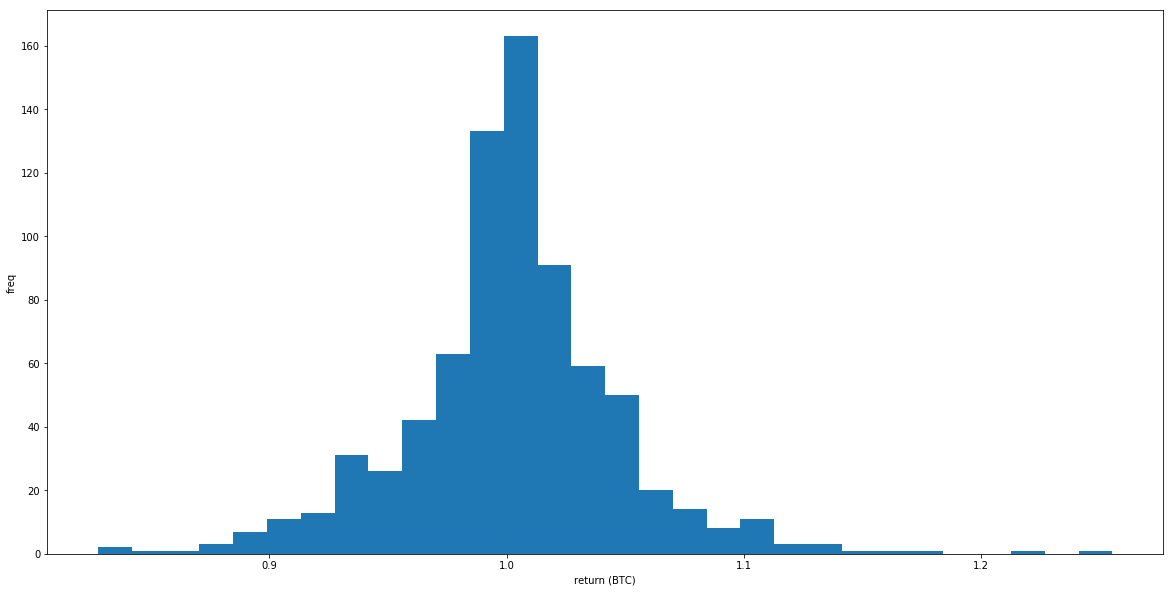

In [15]:
plt.figure(figsize=(20, 10))
plt.hist(df_returns["BTC"], bins=30)
plt.xlabel("return (BTC)")
plt.ylabel("freq")
plt.show()

In practice, we'll log-normalize these returns, to give them approximately zero mean and a very slightly less heavy right tail (only slightly, because for values close to $r = 1$, we have that $r - 1 \approx \log(r)$):

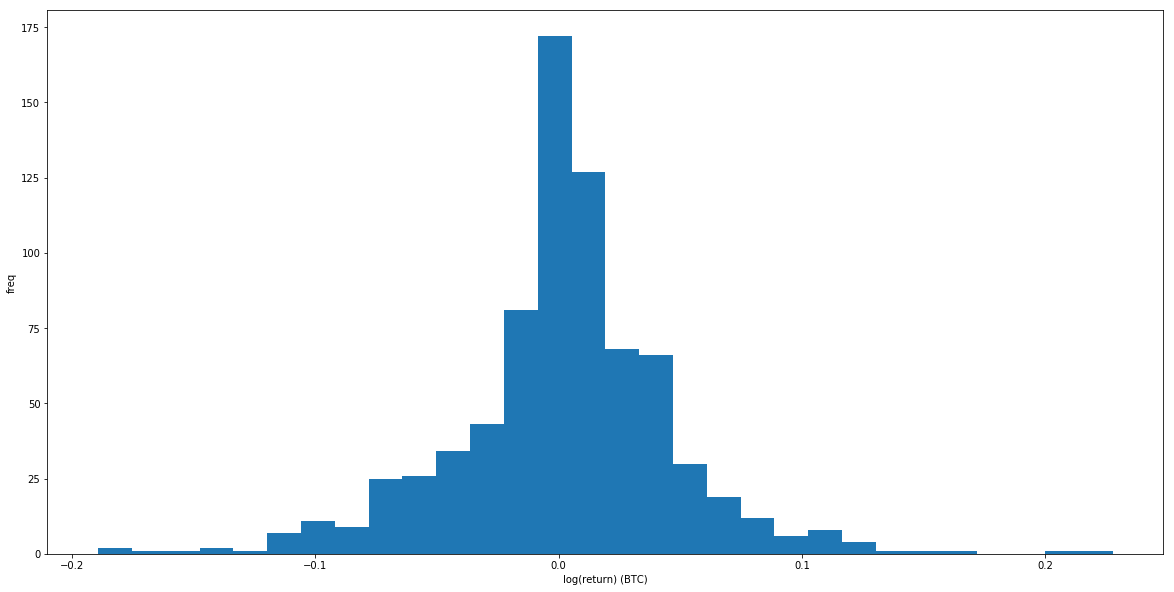

In [16]:
df_logreturns = np.log(df_returns)
plt.figure(figsize=(20, 10))
plt.hist(df_logreturns["BTC"], bins=30)
plt.xlabel("log(return) (BTC)")
plt.ylabel("freq")
plt.show()

We can also plot these returns over time (this time for both Bitcoin and Ethereum):

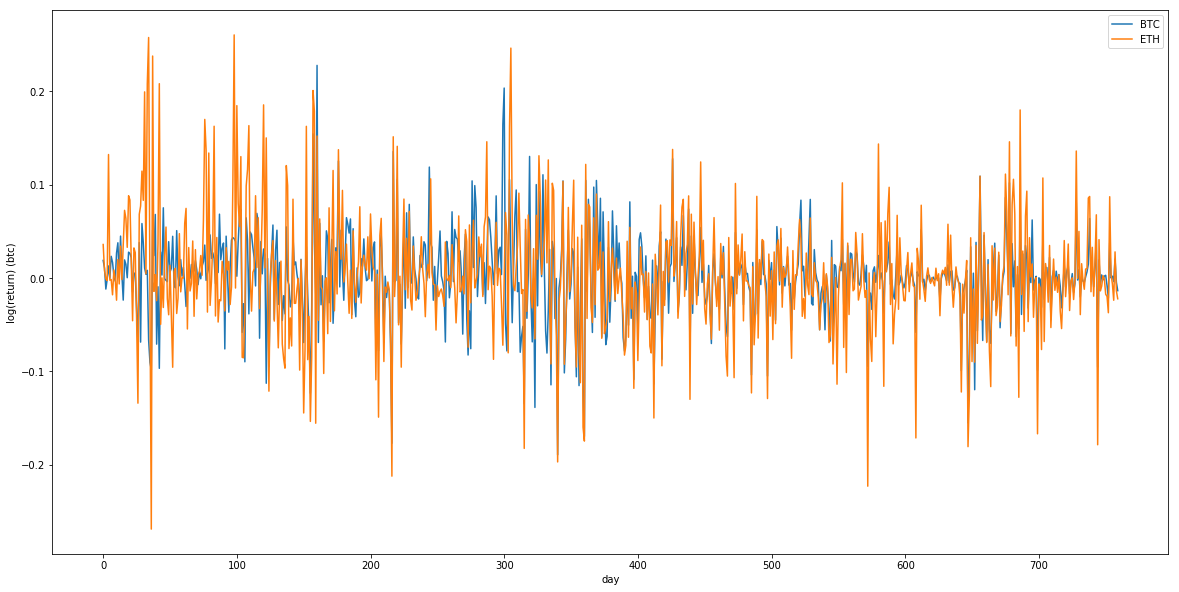

In [246]:
sel = ["BTC", "ETH"]

plt.figure(figsize=(20, 10))
plt.plot(df_logreturns[sel])
plt.legend(sel)
plt.xlabel("day")
plt.ylabel("log(return) (btc)")
plt.show()

Notice the returns are highly, highly correlated - although this isn't exactly a recent phenomenon in crypto, it has been rather extreme over the past year (see e.g. [here](https://www.theblockcrypto.com/2019/01/04/analysis-correlation-between-cryptocurrency-prices-sharply-increased-in-2018/)). This causes many challenges for predictive modeling.

One of the modern problems in econometrics is portfolio choice - that is, how can we choose an optimal portfolio of assets to maximize our returns over time. These high correlations are particularly problematic when computing the maximum tangency portfolio.

I think it would be interesting to see if we can apply modern portfolio theory to cryptocurrencies (which are known to be particularly volatile). It poses unique modeling challenges, and the goal will be to address them.

In [247]:
all_training_data = np.asarray(df_returns).T
all_training_data.shape

(6, 760)

# Goal

Our goal is to build a predictive model for portfolio choice. Formally:

Let $\mathbf{r}(t) \in \mathbb{R}^n$ be the return of each of $n$ assets at time $t$, where $r_i(t) = \log{\frac{x_i(t + 1)}{x_i(t)}}$ for $i = 1, \dots, n$. Then, at any time, the assets have a covariance matrix $\Sigma(t)$ which can be estimated by $S(t) = \mathbf{r}(t) \mathbf{r}(t)^T$. Let our training data be $\{ \mathbf{r}(t) | t \in 1, \dots, T \}$ where $T$ is the number of training timepoints. Our goal is to define a model capable of then predicting $r(T + 1)$ and $\Sigma(T + 1)$. We can then optimize portfolio choice by maximizing the Sharpe ratio:

$$\frac{\mathbf{w}^T \mathbf{r}(T + 1)}{\sqrt{\mathbf{w}^T \Sigma(T + 1) \mathbf{w}}}$$

where $\sum w_i = 1$. This is called the maximum tangency portfolio and is optimally resilient to volatility and maximizes returns.

(Note: we're being deliberately vague about how we're going to compute $\mathbf{r}(T + 1)$ and $\Sigma(T + 1)$ - we'll try a number of different predictive models with the same sort of general idea.)

# Model

There are several possible methods to estimate $\mathbf{r}(T + 1)$:

* Simple regression
* Autoregressive models
* Neural networks (RNNs in particular)
* Bayesian methods

There are also methods (apparently generally lesser-known outside of econometrics) to estimate $\Sigma(T + 1)$, including autoregressive models like MGARCH, but these frequently make problematic assumptions.

A common technique is to model the returns with a model like ARIMA, and the volatility with a model like MGARCH, combining them for forecasting.

I think an interesting idea would be to use ARIMA to predict future returns $\mathbf{r}(t)$, and an alternative to MGARCH (the [generalized Wishart process](https://www.cs.cmu.edu/~andrewgw/gwp.pdf)) to model $\Sigma(t)$. Together, these will produce estimates of $\mathbf{r}(T + 1)$ and $\Sigma(T + 1)$ which can then be used for portfolio choice. The GWP has shown some advantages in highly correlated asset markets, as shown in the original paper, over MGARCH.

(I'm assuming some familiarity with Gaussian processes - [here](https://www.cs.toronto.edu/~hinton/csc2515/notes/gp_slides_fall08.pdf) is a good introduction, and the seminal book is [R&W](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) - chapters 1, 2, 4, and 5 are useful references).

## Generalized Wishart process

The key idea of the generalized Wishart process is summarized in equation (12) of the original paper. Essentially, if $\mathbf{u_i} \sim \mathcal{N}(\mathbf{0}, I)$ for $i = 1, \dots, \nu$, and $L$ is the lower Cholesky factor of a symmetric pd matrix, then $\Sigma = \sum_i L\mathbf{u_i}\mathbf{u_i}^TL^T \sim \mathcal{W}(LL^T, \nu)$. Here, $\mathcal{W}$ is the Wishart distribution, which can be thought of as a distribution over covariance matrices. In our case, $\mathbf{u_i} \in \mathbb{R}^N$, where $N$ is the number of assets we're modeling, and thus $\Sigma$ is a covariance matrix over the assets of interest. If we make the $\mathbf{u_i}$s a "smooth" function of time, then our covariance matrix is _also_ a "smooth" function of time. One easy way to do this is to model the $\mathbf{u_i}$s as zero-mean Gaussian processes, defined entirely by their kernel function (see [here](https://www.cs.toronto.edu/~duvenaud/cookbook/) for a great, short reference). Then, our covariance matrix is completely defined by this kernel function as well.

Below, we define some common kernel functions used in GPs:

In [18]:
def ou(t1, t2, params):
    """
    Ornstein-Uhlenbeck kernel. Commonly used for financial data because
    it's not quite as smooth as the squared-exponential kernel.
    """
    tau = params[0]
    
    return np.exp(-abs(t2 - t1)/tau)

def squared_exponential(t1, t2, params):
    """
    Squared-exponential kernel. This is generally considered the "gold
    standard" in the GP literature because it is universal - within some
    assumptions, it can approximate any continuous function.
    """
    tau = params[0]
    
    return np.exp(-0.5*((t1 - t2)/tau)**2)

def periodic(t1, t2, params):
    """
    A simple periodic kernel function.
    """
    tau = params[0]
    
    return np.exp(-2*np.sin((t1 - t2)/2)**2/tau**2)

There are infinitely many possible kernels, and we can increase the space even more by noticing that sums of kernels are also valid kernels.

We'll now implement the model for $\Sigma(t)$. It's a direct implementation of equations (15)-(17) and the sampling procedure described in the GWP paper. We follow their direction and implement [elliptical slice sampling](http://proceedings.mlr.press/v9/murray10a/murray10a.pdf) for sampling the GPs which construct $\Sigma(t)$. We use the `emcee` library in Python for the Metropolis-Hasting steps (learning $L$ and $\mathbf{\theta}$). The code is in `model/gwp.py`.

In [65]:
from model.gwp import GeneralizedWishartProcess as GWP
from model.kernels import squared_exponential as se

We'll do "windowed" backtesting - train the model on days $i, \dots, i + w - 1$, and predict day $i + w$, for $i = 0, \dots v - 1$, where $v$ is the number of tests and $w$ is the window size. We're constrained by processing power and time, because Gibbs sampling is slow, so we'll use relatively small values to start.

In [248]:
v = 30
w = 10
start = 2*365
D, T = all_training_data.shape

sig_predictions = []
for i in range(start, start + v):
    j = i + w - 1
    train = all_training_data[:, i:(i + w)]
    vr = np.var(train)
    train = train / np.std(train)
    gwp = GWP(0.95, se, 0.0, 1.0, 1.0)
    gwp.fit(train, numit=7_500, progress=250)
    
    sig_predictions.append(gwp.predict_next_timepoint(train, burnin=1_000) * vr)

Iter 0: loglik = -19442.71, log P(u|...) = -18800.74, log P(tau|...) = -217.82, log P(L|...) = -18602.16
Iter 250: loglik = -83.91, log P(u|...) = -297.51, log P(tau|...) = -236.63, log P(L|...) = -130.26
Iter 500: loglik = -46.32, log P(u|...) = -254.94, log P(tau|...) = -231.84, log P(L|...) = -104.20
Iter 750: loglik = -33.22, log P(u|...) = -253.79, log P(tau|...) = -242.67, log P(L|...) = -87.73
Iter 1000: loglik = -42.42, log P(u|...) = -271.90, log P(tau|...) = -250.83, log P(L|...) = -88.54
Iter 1250: loglik = -44.24, log P(u|...) = -261.47, log P(tau|...) = -240.17, log P(L|...) = -88.77
Iter 1500: loglik = -37.88, log P(u|...) = -263.24, log P(tau|...) = -246.02, log P(L|...) = -84.69
Iter 1750: loglik = -37.20, log P(u|...) = -255.43, log P(tau|...) = -240.51, log P(L|...) = -82.39
Iter 2000: loglik = -39.05, log P(u|...) = -245.28, log P(tau|...) = -228.56, log P(L|...) = -83.59
Iter 2250: loglik = -38.41, log P(u|...) = -257.69, log P(tau|...) = -241.51, log P(L|...) = -84

Iter 5500: loglik = -29.77, log P(u|...) = -217.65, log P(tau|...) = -221.05, log P(L|...) = -74.09
Iter 5750: loglik = -32.94, log P(u|...) = -230.44, log P(tau|...) = -230.90, log P(L|...) = -77.03
Iter 6000: loglik = -31.76, log P(u|...) = -234.12, log P(tau|...) = -235.66, log P(L|...) = -75.95
Iter 6250: loglik = -23.80, log P(u|...) = -248.49, log P(tau|...) = -265.62, log P(L|...) = -69.03
Iter 6500: loglik = -27.35, log P(u|...) = -229.25, log P(tau|...) = -243.21, log P(L|...) = -69.05
Iter 6750: loglik = -30.79, log P(u|...) = -256.83, log P(tau|...) = -271.36, log P(L|...) = -72.80
Iter 7000: loglik = -33.38, log P(u|...) = -247.61, log P(tau|...) = -260.07, log P(L|...) = -74.88
Iter 7250: loglik = -24.65, log P(u|...) = -238.41, log P(tau|...) = -259.37, log P(L|...) = -66.37
Optimal likelihood: -19.637
Iter 0: loglik = -32375.28, log P(u|...) = -14113.11, log P(tau|...) = -220.16, log P(L|...) = -13911.01
Iter 250: loglik = -44.49, log P(u|...) = -271.92, log P(tau|...) =

Iter 3250: loglik = -23.31, log P(u|...) = -222.62, log P(tau|...) = -236.48, log P(L|...) = -65.30
Iter 3500: loglik = -28.82, log P(u|...) = -229.06, log P(tau|...) = -238.85, log P(L|...) = -65.67
Iter 3750: loglik = -20.47, log P(u|...) = -229.23, log P(tau|...) = -245.91, log P(L|...) = -62.76
Iter 4000: loglik = -21.23, log P(u|...) = -209.11, log P(tau|...) = -225.34, log P(L|...) = -63.32
Iter 4250: loglik = -28.42, log P(u|...) = -197.51, log P(tau|...) = -207.69, log P(L|...) = -65.81
Iter 4500: loglik = -27.51, log P(u|...) = -231.22, log P(tau|...) = -240.07, log P(L|...) = -62.33
Iter 4750: loglik = -21.62, log P(u|...) = -226.76, log P(tau|...) = -257.89, log P(L|...) = -58.83
Iter 5000: loglik = -34.02, log P(u|...) = -269.41, log P(tau|...) = -283.19, log P(L|...) = -71.86
Iter 5250: loglik = -22.94, log P(u|...) = -220.91, log P(tau|...) = -244.53, log P(L|...) = -62.69
Iter 5500: loglik = -27.89, log P(u|...) = -226.43, log P(tau|...) = -245.89, log P(L|...) = -66.31


Iter 1250: loglik = -48.03, log P(u|...) = -251.82, log P(tau|...) = -233.99, log P(L|...) = -68.18
Iter 1500: loglik = -38.68, log P(u|...) = -234.90, log P(tau|...) = -224.13, log P(L|...) = -59.27
Iter 1750: loglik = -30.27, log P(u|...) = -241.51, log P(tau|...) = -239.02, log P(L|...) = -52.86
Iter 2000: loglik = -26.89, log P(u|...) = -209.56, log P(tau|...) = -219.43, log P(L|...) = -51.66
Iter 2250: loglik = -24.90, log P(u|...) = -237.86, log P(tau|...) = -249.38, log P(L|...) = -50.28
Iter 2500: loglik = -21.06, log P(u|...) = -193.75, log P(tau|...) = -208.44, log P(L|...) = -47.12
Iter 2750: loglik = -22.80, log P(u|...) = -209.98, log P(tau|...) = -223.20, log P(L|...) = -48.59
Iter 3000: loglik = -25.51, log P(u|...) = -221.23, log P(tau|...) = -231.98, log P(L|...) = -51.06
Iter 3250: loglik = -26.76, log P(u|...) = -231.87, log P(tau|...) = -241.58, log P(L|...) = -55.26
Iter 3500: loglik = -20.58, log P(u|...) = -227.49, log P(tau|...) = -243.58, log P(L|...) = -49.82


Iter 6750: loglik = -19.24, log P(u|...) = -229.57, log P(tau|...) = -247.62, log P(L|...) = -51.29
Iter 7000: loglik = -22.39, log P(u|...) = -210.26, log P(tau|...) = -226.18, log P(L|...) = -53.41
Iter 7250: loglik = -26.40, log P(u|...) = -229.43, log P(tau|...) = -241.10, log P(L|...) = -52.33
Optimal likelihood: -15.666
Iter 0: loglik = -29191.48, log P(u|...) = -10564.77, log P(tau|...) = -254.22, log P(L|...) = -7064.27
Iter 250: loglik = -121.33, log P(u|...) = -326.38, log P(tau|...) = -232.12, log P(L|...) = -138.72
Iter 500: loglik = -58.54, log P(u|...) = -266.67, log P(tau|...) = -240.94, log P(L|...) = -81.70
Iter 750: loglik = -38.96, log P(u|...) = -230.02, log P(tau|...) = -223.57, log P(L|...) = -67.59
Iter 1000: loglik = -38.50, log P(u|...) = -244.22, log P(tau|...) = -232.38, log P(L|...) = -67.90
Iter 1250: loglik = -41.79, log P(u|...) = -274.89, log P(tau|...) = -261.50, log P(L|...) = -69.17
Iter 1500: loglik = -31.82, log P(u|...) = -251.53, log P(tau|...) = 

Iter 4750: loglik = -38.26, log P(u|...) = -239.31, log P(tau|...) = -228.46, log P(L|...) = -67.22
Iter 5000: loglik = -34.43, log P(u|...) = -242.87, log P(tau|...) = -236.01, log P(L|...) = -63.23
Iter 5250: loglik = -36.64, log P(u|...) = -242.37, log P(tau|...) = -234.06, log P(L|...) = -64.68
Iter 5500: loglik = -34.32, log P(u|...) = -235.26, log P(tau|...) = -229.09, log P(L|...) = -67.44
Iter 5750: loglik = -34.29, log P(u|...) = -246.42, log P(tau|...) = -239.50, log P(L|...) = -70.22
Iter 6000: loglik = -30.36, log P(u|...) = -232.39, log P(tau|...) = -230.45, log P(L|...) = -67.71
Iter 6250: loglik = -28.72, log P(u|...) = -229.08, log P(tau|...) = -228.63, log P(L|...) = -64.65
Iter 6500: loglik = -19.96, log P(u|...) = -225.54, log P(tau|...) = -233.45, log P(L|...) = -56.28
Iter 6750: loglik = -29.40, log P(u|...) = -238.11, log P(tau|...) = -237.00, log P(L|...) = -65.31
Iter 7000: loglik = -21.13, log P(u|...) = -213.02, log P(tau|...) = -219.69, log P(L|...) = -59.29


Iter 2500: loglik = -72.07, log P(u|...) = -311.75, log P(tau|...) = -287.26, log P(L|...) = -90.04
Iter 2750: loglik = -76.69, log P(u|...) = -297.50, log P(tau|...) = -268.22, log P(L|...) = -94.83
Iter 3000: loglik = -72.58, log P(u|...) = -303.77, log P(tau|...) = -278.77, log P(L|...) = -90.55
Iter 3250: loglik = -66.82, log P(u|...) = -308.30, log P(tau|...) = -288.82, log P(L|...) = -85.03
Iter 3500: loglik = -85.07, log P(u|...) = -309.95, log P(tau|...) = -271.09, log P(L|...) = -104.76
Iter 3750: loglik = -71.18, log P(u|...) = -315.50, log P(tau|...) = -292.91, log P(L|...) = -88.48
Iter 4000: loglik = -68.02, log P(u|...) = -297.55, log P(tau|...) = -277.53, log P(L|...) = -85.91
Iter 4250: loglik = -57.25, log P(u|...) = -280.90, log P(tau|...) = -271.39, log P(L|...) = -79.92
Iter 4500: loglik = -56.43, log P(u|...) = -290.14, log P(tau|...) = -284.24, log P(L|...) = -80.49
Iter 4750: loglik = -56.77, log P(u|...) = -266.28, log P(tau|...) = -257.13, log P(L|...) = -81.54

Iter 250: loglik = -90.35, log P(u|...) = -306.43, log P(tau|...) = -234.31, log P(L|...) = -122.19
Iter 500: loglik = -67.15, log P(u|...) = -280.71, log P(tau|...) = -227.24, log P(L|...) = -104.09
Iter 750: loglik = -54.17, log P(u|...) = -265.53, log P(tau|...) = -239.32, log P(L|...) = -101.04
Iter 1000: loglik = -37.87, log P(u|...) = -245.33, log P(tau|...) = -235.79, log P(L|...) = -85.37
Iter 1250: loglik = -45.09, log P(u|...) = -251.16, log P(tau|...) = -233.83, log P(L|...) = -95.98
Iter 1500: loglik = -29.26, log P(u|...) = -245.30, log P(tau|...) = -242.81, log P(L|...) = -88.59
Iter 1750: loglik = -31.46, log P(u|...) = -232.82, log P(tau|...) = -229.21, log P(L|...) = -97.78
Iter 2000: loglik = -29.82, log P(u|...) = -254.81, log P(tau|...) = -252.96, log P(L|...) = -92.39
Iter 2250: loglik = -32.88, log P(u|...) = -231.74, log P(tau|...) = -233.66, log P(L|...) = -96.24
Iter 2500: loglik = -34.72, log P(u|...) = -246.19, log P(tau|...) = -242.79, log P(L|...) = -98.69


Iter 5750: loglik = -32.97, log P(u|...) = -181.20, log P(tau|...) = -192.24, log P(L|...) = -78.48
Iter 6000: loglik = -25.67, log P(u|...) = -189.48, log P(tau|...) = -206.47, log P(L|...) = -72.53
Iter 6250: loglik = -32.19, log P(u|...) = -221.01, log P(tau|...) = -231.26, log P(L|...) = -77.25
Iter 6500: loglik = -28.06, log P(u|...) = -209.52, log P(tau|...) = -224.35, log P(L|...) = -72.67
Iter 6750: loglik = -30.89, log P(u|...) = -203.78, log P(tau|...) = -215.66, log P(L|...) = -72.79
Iter 7000: loglik = -35.70, log P(u|...) = -217.06, log P(tau|...) = -224.65, log P(L|...) = -81.43
Iter 7250: loglik = -29.01, log P(u|...) = -208.51, log P(tau|...) = -219.75, log P(L|...) = -72.21
Optimal likelihood: -18.604
Iter 0: loglik = -77197.19, log P(u|...) = -52604.94, log P(tau|...) = -193.55, log P(L|...) = -52436.72
Iter 250: loglik = -209.66, log P(u|...) = -416.18, log P(tau|...) = -229.13, log P(L|...) = -219.94
Iter 500: loglik = -95.92, log P(u|...) = -301.89, log P(tau|...) 

Iter 3500: loglik = -40.72, log P(u|...) = -187.52, log P(tau|...) = -182.83, log P(L|...) = -59.47
Iter 3750: loglik = -42.28, log P(u|...) = -203.44, log P(tau|...) = -195.42, log P(L|...) = -62.80
Iter 4000: loglik = -32.95, log P(u|...) = -161.64, log P(tau|...) = -164.01, log P(L|...) = -57.53
Iter 4250: loglik = -31.98, log P(u|...) = -185.31, log P(tau|...) = -188.56, log P(L|...) = -56.65
Iter 4500: loglik = -33.99, log P(u|...) = -180.15, log P(tau|...) = -174.44, log P(L|...) = -61.24
Iter 4750: loglik = -36.52, log P(u|...) = -178.18, log P(tau|...) = -169.89, log P(L|...) = -67.80
Iter 5000: loglik = -28.12, log P(u|...) = -160.16, log P(tau|...) = -160.55, log P(L|...) = -62.12
Iter 5250: loglik = -22.78, log P(u|...) = -136.31, log P(tau|...) = -142.05, log P(L|...) = -56.78
Iter 5500: loglik = -31.21, log P(u|...) = -149.26, log P(tau|...) = -146.70, log P(L|...) = -65.07
Iter 5750: loglik = -22.17, log P(u|...) = -142.26, log P(tau|...) = -148.59, log P(L|...) = -56.50


Iter 1500: loglik = -17.76, log P(u|...) = -77.24, log P(tau|...) = -94.91, log P(L|...) = -46.74
Iter 1750: loglik = -21.41, log P(u|...) = -85.53, log P(tau|...) = -99.04, log P(L|...) = -52.01
Iter 2000: loglik = -19.90, log P(u|...) = -90.99, log P(tau|...) = -106.56, log P(L|...) = -49.80
Iter 2250: loglik = -15.91, log P(u|...) = -73.29, log P(tau|...) = -91.55, log P(L|...) = -52.50
Iter 2500: loglik = -15.32, log P(u|...) = -78.32, log P(tau|...) = -99.72, log P(L|...) = -46.35
Iter 2750: loglik = -15.80, log P(u|...) = -88.84, log P(tau|...) = -103.93, log P(L|...) = -44.37
Iter 3000: loglik = -16.23, log P(u|...) = -89.47, log P(tau|...) = -104.33, log P(L|...) = -49.35
Iter 3250: loglik = -24.03, log P(u|...) = -89.86, log P(tau|...) = -96.61, log P(L|...) = -55.26
Iter 3500: loglik = -11.73, log P(u|...) = -80.62, log P(tau|...) = -99.66, log P(L|...) = -44.73
Iter 3750: loglik = -19.74, log P(u|...) = -80.65, log P(tau|...) = -90.86, log P(L|...) = -54.41
Iter 4000: loglik

Iter 7250: loglik = -13.96, log P(u|...) = -54.37, log P(tau|...) = -57.54, log P(L|...) = -42.10
Optimal likelihood: -11.283


Because we're using the MAP (maximum _a posteriori_) estimate, we sometimes get odd behaviour. If we had the computing power, we'd run this for many more iterations (say, at least 25k instead of 7.5k) and don't use windowing at all but rather something like a periodic\*quadratic kernel to account for time-dependent variation, and use the full modeling time period (2+ years). In practice, this odd behaviour results in predictions of $\Sigma$ that are singular. Depending on your luck when running this notebook, you may experience this. The code in section 4.3 accounts for this so there should be no errors, however, understand that this is less than ideal.

__Note:__ It could have been avoided by checking the positive definite-ness of the matrix manually in the Gibbs sampling routine and using some tricks to keep away from local minima. I forgot to do this, and the model takes too long to run on my computer to re-do it at this point.

## ARIMA

In order to fulfill our goal of a fully automatic portfolio choice algorithm, we also need to somehow predict $\mathbf{r}(t)$. We'll use a basic ARI ($\text{ARIMA}(w, 1, 0)$) model to do so.

There's an existing implementation in the `statsmodels` package. We'll use that rather than implementing our own. Generally, we'd expect our model to perform better the more data it has (unless there's some significant change to the latent variables which determine the return over time - which is entirely possible), and because it's a simple linear regression we're not constrained by computing power or time. So we'll give it 2 years of historical data, in addition to the data we give to the GWP model.

We'll now fit the model in much the same way we fit the GWP model:

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [250]:
for i in range(start, start + v):
    j = i + w - 1
    train = np.log(all_training_data[:, 0:(i + w)])
    std = np.std(train)
    train = train / std
    pred = []
    for n in range(train.shape[0]):
        fit = ARIMA(train[n, :], order=(10, 1, 0)).fit()
        pred.append(fit.predict(train.shape[1])[0])
    
    r_predictions.append(np.asarray(pred) * std)

In [258]:
true = all_training_data[:, 730:]
(np.sign(r_predictions).T == np.sign(np.log(true))).sum() / np.prod(true.shape)

0.5888888888888889

So, we predict the right direction in the model 59% of the time - slightly better than chance (50%). This suggests that maybe the ARIMA model on its own is only marginally useful. Despite this, can we still make optimal portfolio decisions by incorporating variance information?

## Maximum tangency portfolio

We'll now implement the code to maximize the Sharpe ratio. This has a straightforward closed form:

$$\mathbf{w} = \frac{\Sigma^{-1}\mathbf{r}}{\mathbf{1}^T \Sigma^{-1} \mathbf{r}}$$

However, this formula assumes the ability to short assets - that is, elements of $\mathbf{w}$ can be negative. It's very difficult to short crypto assets at volume so in practice we'll constrain the elements of $\mathbf{w}$ to be positive and perform gradient-based optimization of the Sharpe ratio:

$$\frac{\mathbf{w}^T \mathbf{r}(T + 1)}{\sqrt{\mathbf{w}^T \Sigma(T + 1) \mathbf{w}}}$$

__Note:__ This is *not* actually the maximum tangency portfolio - in fact, it doesn't even lie on the efficient frontier! However, the Sharpe ratio is still an effective way to quantify risk and reward, even under these constraints. There may be a closed form under these constraints as well, but I couldn't find it in the literature.

In [336]:
def choose_shortless_portfolio(r, cov):
    def objective(w):
        return -np.dot(w, r) / np.sqrt(np.matmul(w, np.matmul(cov, w)))
    
    w0 = np.random.lognormal(size=len(r))
    w0 = w0 / np.sum(w0)
    
    opt = minimize(
        objective,
        w0,
        constraints=[{ 'type': 'eq', 'fun': lambda w: np.sum(w) - 1 }],
        bounds=[
            (0.0, 1.0) for _ in range(len(r))
        ]
    )
    
    if opt.success:
        return opt.x
    else:
        raise(Exception("Optimization failed!"))

Then, given our predictions, we can compute the hypothetical return on a portfolio selected based on this computation for all of the predicted days. Note that if the GWP prediction failed (singular matrix) we simply don't buy any assets that day.

In [349]:
def compute_shortless_return(r_pred, sig_pred, data):
    total = 1
    for day in range(len(r_pred)):
        if np.linalg.matrix_rank(sig_pred[day]) != sig_pred[day].shape[0]:
            print("GWP prediction failed. Not investing returns for day {}.".format(day))
        else:
            w = choose_shortless_portfolio(r_pred[day], sig_pred[day])
            hypothetical_return = np.dot(w, data[:, day])
            total *= hypothetical_return
            print("Day {}: return = {}, running return = {}".format(
                day, hypothetical_return, total
            ))
    
    return total

Giving an overall return of:

In [350]:
compute_shortless_return(r_predictions, sig_predictions, all_training_data[:, 730:])

Day 0: return = 1.0512305374183828, running return = 1.0512305374183828
Day 1: return = 1.013598738667955, running return = 1.0655259467765092
Day 2: return = 1.0246994540459364, running return = 1.0918438559336685
Day 3: return = 0.9925055721803645, running return = 1.0836611109650611
Day 4: return = 1.009770266701875, running return = 1.09424876903364
Day 5: return = 1.030627358443802, running return = 1.1277627183095222
Day 6: return = 1.0066091738115321, running return = 1.1352162981329958
Day 7: return = 1.0097834678565742, running return = 1.1463226502960393
Day 8: return = 1.057436946801805, running return = 1.212163923378797
Day 9: return = 0.9882967230824631, running return = 1.197977633314047
Day 10: return = 1.0233558696988325, running return = 1.2259574428198456
Day 11: return = 0.9807679421027952, running return = 1.202379758300025
Day 12: return = 1.0114899168752483, running return = 1.2161950017753735
Day 13: return = 1.0435132957292508, running return = 1.26911565455206

1.2328254992336969

which doesn't look too bad. How would it compare to just re-investing returns day over day in BTC? Or in an equally distributed basket?

In [276]:
print(np.prod(all_training_data[0, 730:]))
print(np.prod(np.sum(all_training_data[:, 730:], axis=0)/all_training_data.shape[0]))

1.0615947386002094
1.1137031745365735


A fair bit better! 23.3% rate of return over thirty days isn't bad at all, compared to 11.4% from an equally distributed basket.

# Conclusions

We built a reasonable model of portfolio choice for cryptocurrency returns. Given more time, there is still much to do:

* Compare to a model like MGARCH (easy to do in R)
* Improve the speed of the code
  - Kernel functions can be implemented in C, or make use of a library like `george`
  - Block-diagonal matrix inverses can be sped up in the case of the GWP
  - Message-passing implementation of model fitting may be possible - much faster than Gibbs sampling
* Custom `corner` plots to investigate the relationship between the $\tau$ parameters and $L$
* Live plotting of model fitting
* Smarter initialization procedures to speed up convergence

We made some rather poor assumptions throughout the code as well. For example:

* We don't run the model for enough iterations - we basically rely on getting "lucky" initializations and MCMC chains.
* As mentioned above, we don't check for singularities, so sometimes predictions fail.
* We assume the empirical mode (for GWP) is in fact the best estimate of each parameter, when in practice one usually examines the quantiles for each parameter and makes some sort of educated decision about the final predictive parameters in the model. I believe in this case the mode is better when running for low number of iterations, because of the highly correlated prior on $u$.

Additionally, there is a major flaw in our model: we don't account for the uncertainty of our estimates when predicting volatility. There is a better model that solves this.

It's called a [Gaussian process regression network](https://arxiv.org/pdf/1110.4411.pdf). There is an Infer.NET implementation, but it is outdated (8 years old) and it's non-trivial to get it running with the current version of Infer.NET. An implementation in Python is definitely possible: one can fit it using MCMC or VB. The model looks something like this:

$$\mathbf{r}(t) = W(t)[\mathbf{f}(t) + \sigma_f \mathbf{\epsilon}] + \sigma_r \mathbf{z}$$

Here, $W(t)$ is a matrix of GPs such that $W_{ij}(t) \sim \mathcal{GP}(0, k_w(t, t'))$ and $f(t)$ is a vector of GPs such that $f(t) \sim \mathcal{GP}(0, k_f(t, t'))$. Note that we maintain many of the same benefits of the ARIMA+GWP model we implemented above. However, the joint estimation of $W(t)$ (which, when coupled with the $\epsilon$ noise model is analogous to the GWP in our model) and $f(t)$ (which is analogous to the ARIMA model) will almost certainly produce superior results on any prediction task.

If we wanted to stay within the ARIMA framework, we might be able to do something like joint Bayesian optimization of an ARIMA+GWP model, where we iteratively optimize the GWP parameters and the ARIMA parameters, simply by adding an ARIMA parameter fitting step to the Gibbs sampling procedure above.